In [74]:

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sys
import matplotlib.pyplot as plt  
import os 
from concurrent.futures import ThreadPoolExecutor ,ProcessPoolExecutor,as_completed
import joblib
import time
import subprocess
import os
import joblib
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
import numpy as np
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)


In [33]:
cwd = os.getcwd()
# Construct the full path to the 'FPL' directory
fpl_path = os.path.join(cwd, '..', '..', 'FPL')
# Add it to the system path
sys.path.append(fpl_path)
from fpl_api_collection import (
    get_bootstrap_data,
    get_current_gw,
    get_fixt_dfs,
    get_fixture_data,
    get_player_id_dict,
    get_current_season,
    get_player_data,
)

In [34]:
# Retrieve and prepare player data
ele_types_data = get_bootstrap_data()['element_types']
ele_types_X_weighted = pd.DataFrame(ele_types_data)
ele_data = get_bootstrap_data()['elements']
ele_df = pd.DataFrame(ele_data)
ele_df['element_type'] = ele_df['element_type'].map(ele_types_X_weighted.set_index('id')['singular_name_short'])
ele_copy = ele_df.copy()

# Retrieve and prepare team data
teams_data = get_bootstrap_data()['teams']
teams_df = pd.DataFrame(teams_data)

# Map team IDs to names for fixture processing
team_name_mapping = pd.Series(teams_df.name.values, index=teams_df.id).to_dict()
ele_copy['team_name'] = ele_copy['team'].map(teams_df.set_index('id')['short_name'])
ele_copy['full_name'] = ele_copy['first_name'].str.cat(ele_copy['second_name'].str.cat(ele_copy['team_name'].apply(lambda x: f" ({x})"), sep=''), sep=' ')

# Retrieve player dictionary and current season/gameweek
full_player_dict = get_player_id_dict('total_points', web_name=False)
crnt_season = get_current_season()
ct_gw = get_current_gw()

# Retrieve and process fixture data
fixture_data = get_fixture_data()
fixtures_df = pd.DataFrame(fixture_data)
fixtures_df.drop(columns='stats', inplace=True)

fixtures_df['team_h'] = fixtures_df['team_h'].replace(team_name_mapping)
fixtures_df['team_a'] = fixtures_df['team_a'].replace(team_name_mapping)
fixtures_df = fixtures_df.drop(columns=['pulse_id'])

# Format fixture dates
timezone = 'Europe/London'
fixtures_df['datetime'] = pd.to_datetime(fixtures_df['kickoff_time'], utc=True)
fixtures_df['local_time'] = fixtures_df['datetime'].dt.tz_convert(timezone).dt.strftime('%A %d %B %Y %H:%M')
fixtures_df['local_date'] = fixtures_df['datetime'].dt.tz_convert(timezone).dt.strftime('%d %A %B %Y')
fixtures_df['local_hour'] = fixtures_df['datetime'].dt.tz_convert(timezone).dt.strftime('%H:%M')

# Retrieve fixture difficulty rating data
team_fdr_df, team_fixt_df, team_ga_df, team_gf_df = get_fixt_dfs()
full_player_dict = get_player_id_dict('total_points', web_name=False)

In [35]:
def convert_score_to_result(df):
    df.loc[df['was_home'] == True, 'result'] = df['team_h_score'] \
        .astype('Int64').astype(str) \
        + '-' + df['team_a_score'].astype('Int64').astype(str)
    df.loc[df['was_home'] == False, 'result'] = df['team_a_score'] \
        .astype('Int64').astype(str) \
        + '-' + df['team_h_score'].astype('Int64').astype(str)
        
def convert_opponent_string(df):
    df.loc[df['was_home'] == True, 'vs'] = df['vs'] + ' (A)'
    df.loc[df['was_home'] == False, 'vs'] = df['vs'] + ' (H)'
    df.loc[df['was_home'] == True, 'Team_player'] = df['Team_player'] + ' (H)'
    df.loc[df['was_home'] == False, 'Team_player'] = df['Team_player'] + ' (A)'
    return df

def collate_hist_df_from_name(player_name):
    p_id = [k for k, v in full_player_dict.items() if v == player_name]
    position = ele_copy.loc[ele_copy['full_name'] == player_name, 'element_type'].iloc[0]
    Team = ele_copy.loc[ele_copy['full_name'] == player_name, 'team_name'].iloc[0]
    p_data = get_player_data(str(p_id[0]))
    p_df = pd.DataFrame(p_data['history'])
    convert_score_to_result(p_df)
    p_df.loc[p_df['result'] == '<NA>-<NA>', 'result'] = '-'
    rn_dict = {'round': 'GW','kickoff_time':'kickoff_time', 'opponent_team': 'vs', 'total_points': 'Pts',
               'minutes': 'Mins', 'goals_scored': 'GS', 'assists': 'A',
               'clean_sheets': 'CS', 'goals_conceded': 'GC', 'own_goals': 'OG',
               'penalties_saved': 'Pen_Save', 'penalties_missed': 'Pen_Miss',
               'yellow_cards': 'YC', 'red_cards': 'RC', 'saves': 'S',
               'bonus': 'B', 'bps': 'BPS', 'influence': 'I', 'creativity': 'C',
               'threat': 'T', 'ict_index': 'ICT', 'value': 'Price',
               'selected': 'SB', 'transfers_in': 'Tran_In',
               'transfers_out': 'Tran_Out', 'expected_goals': 'xG',
               'expected_assists': 'xA', 'expected_goal_involvements': 'xGI',
               'expected_goals_conceded': 'xGC', 'result': 'Result'}
    p_df.rename(columns=rn_dict, inplace=True)
    col_order = ['GW','kickoff_time', 'vs', 'Result', 'Pts', 'Mins', 'GS', 'xG', 'A', 'xA',
                 'xGI', 'Pen_Miss', 'CS', 'GC', 'xGC', 'OG', 'Pen_Save', 'S',
                 'YC', 'RC', 'B', 'BPS', 'Price', 'I', 'C', 'T', 'ICT', 'SB',
                 'Tran_In', 'Tran_Out', 'was_home']
    p_df = p_df[col_order]
    # map opponent teams
    
    p_df['Price'] = p_df['Price']/10
    p_df['vs'] = p_df['vs'].map(teams_df.set_index('id')['short_name'])
    p_df['Pos'] = position
    p_df['Team_player'] = Team
    #convert_opponent_string(p_df)
    #p_df.drop('was_home', axis=1, inplace=True)
    #p_df.set_index('GW', inplace=True)
    p_df.sort_values('GW', ascending=False, inplace=True)
    return p_df

In [36]:
def collate_all_players_parallel(full_player_dict, max_workers=None):
    # Determine optimal max_workers if not provided
    if max_workers is None:
        max_workers = os.cpu_count() * 2  # Suitable for I/O-bound tasks like web scraping

    # Define a helper function to retrieve data for a single player
    def get_player_data(player_name):
        try:  # Add exception handling inside the worker function
            player_df = collate_hist_df_from_name(player_name)
            player_df['Player'] = player_name  # Add player name column
            return player_df
        except Exception as e:
            print(f"Error processing {player_name}: {e}")
            return pd.DataFrame() # Return empty DataFrame on error


    # Use ThreadPoolExecutor with a with statement for proper resource management
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit tasks and store futures in a dictionary for easier error handling
        futures = {executor.submit(get_player_data, player_name): player_name 
                   for player_name in full_player_dict.values()}

        results = []
        for future in as_completed(futures):
            player_name = futures[future]
            try:
                result_df = future.result()  # Get the result or raise an exception
                results.append(result_df)
            except Exception as e:
                print(f"Error retrieving result for {player_name}: {e}")

    # Concatenate all successful results into a single DataFrame outside the loop
    all_players_df = pd.concat(results, axis=0, ignore_index=True)  # ignore_index for cleaner index
    return all_players_df

In [37]:
all_players_data = collate_all_players_parallel(full_player_dict)

In [38]:
merged_home = pd.merge(all_players_data, teams_df[['short_name',
                                                    'strength_overall_home', 
                                                    'strength_overall_away', 
                                                    'strength_attack_home', 
                                                    'strength_attack_away', 
                                                    'strength_defence_home', 
                                                    'strength_defence_away']],
                       left_on='Team_player', 
                       right_on='short_name', 
                       how='left')

# Merge for the opponent team
merged_opponent = pd.merge(merged_home, 
                            teams_df[['short_name',
                                       'strength_overall_home', 
                                       'strength_overall_away', 
                                       'strength_attack_home', 
                                       'strength_attack_away', 
                                       'strength_defence_home', 
                                       'strength_defence_away']],
                            left_on='vs', 
                            right_on='short_name', 
                            how='left', 
                            suffixes=('', '_opponent'))

# Optionally drop the 'short_name' columns for opponents if you don't need them
merged_opponent = merged_opponent.drop(columns=['short_name', 'short_name_opponent'])
merged_opponent=convert_opponent_string(merged_opponent)


In [39]:
team_fdr_df, team_fixt_df, team_ga_df, team_gf_df = get_fixt_dfs()

ct_gw = get_current_gw()

new_fixt_df = team_fixt_df.loc[:, ct_gw:(ct_gw+2)]
new_fixt_cols = ['GW' + str(col) for col in new_fixt_df.columns.tolist()]
new_fixt_df.columns = new_fixt_cols

new_fdr_df = team_fdr_df.loc[:, ct_gw:(ct_gw+2)]

def get_home_away_str_dict():
    new_fdr_df.columns = new_fixt_cols
    result_dict = {}
    for col in new_fdr_df.columns:
        values = list(new_fdr_df[col])
        max_length = new_fixt_df[col].str.len().max()
        if max_length > 7:
            new_fixt_df.loc[new_fixt_df[col].str.len() <= 7, col] = new_fixt_df[col].str.pad(width=max_length+9, side='both', fillchar=' ')
        strings = list(new_fixt_df[col])
        value_dict = {}
        for value, string in zip(values, strings):
            if value not in value_dict:
                value_dict[value] = []
            value_dict[value].append(string)
        result_dict[col] = value_dict
    
    merged_dict = {}
    for k, dict1 in result_dict.items():
        for key, value in dict1.items():
            if key in merged_dict:
                merged_dict[key].extend(value)
            else:
                merged_dict[key] = value
    for k, v in merged_dict.items():
        decoupled_list = list(set(v))
        merged_dict[k] = decoupled_list
    for i in range(1,6):
        if i not in merged_dict:
            merged_dict[i] = []
    return merged_dict
	
	

In [40]:
sui=get_home_away_str_dict()

In [41]:
team_fdr_df, team_fixt_df, team_ga_df, team_gf_df = get_fixt_dfs()

ct_gw = get_current_gw()

new_fixt_df = team_fixt_df.loc[:, ct_gw:(ct_gw+2)]
new_fixt_cols = ['GW' + str(col) for col in new_fixt_df.columns.tolist()]
new_fixt_df.columns = new_fixt_cols

def create_team_fdr_dataframe():
    # Create a list to store the results
    team_fdr_list = []
    for col in new_fdr_df.columns:
        # Get the values from the FDR DataFrame
        fdr_values = new_fdr_df[col].values
        # Get the corresponding teams from the fixture DataFrame
        teams = new_fixt_df[col].values
        # Combine teams with their FDR values into the list
        for team, fdr in zip(teams, fdr_values):
            # Ensure that we don't include empty FDR values or teams
            if pd.notna(fdr) and fdr > 0:  # Adjust condition as needed
                team_fdr_list.append({'team': team.strip(), 'fdr': fdr})
    # Create a DataFrame from the list
    team_fdr_df = pd.DataFrame(team_fdr_list)
    return team_fdr_df

# Example usage
team_fdr_df = create_team_fdr_dataframe()


In [42]:
team_fdr_map = dict(zip(team_fdr_df['team'], team_fdr_df['fdr']))
# Map the 'fdr' values to the 'merged_opponent' dataframe based on the 'Team_player' column
merged_opponent['Team_fdr'] = merged_opponent['Team_player'].map(team_fdr_map)
merged_opponent['opponent_fdr'] = merged_opponent['vs'].map(team_fdr_map)

In [43]:
columns_to_convert = ['GW', 'Pts', 'Mins', 'GS', 'xG', 'A', 'xA', 'xGI', 'Pen_Miss', 
                      'CS', 'GC', 'xGC', 'OG', 'Pen_Save', 'S', 'YC', 'RC', 'B', 'BPS', 
                      'Price', 'I', 'C', 'T', 'ICT', 'SB', 'Tran_In', 'Tran_Out', 
                      'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 'strength_attack_away', 
                      'strength_defence_home', 'strength_defence_away', 'strength_overall_home_opponent', 
                      'strength_overall_away_opponent', 'strength_attack_home_opponent', 'strength_attack_away_opponent', 
                      'strength_defence_home_opponent', 'strength_defence_away_opponent', 'Team_fdr', 'opponent_fdr']


# Convert specified columns to float
for col in columns_to_convert:
    merged_opponent[col] = pd.to_numeric(merged_opponent[col], errors='coerce')  # Convert to float and set errors to NaN if conversion fails


In [44]:
merged_opponent['season']=2425
next_fixture_gw = fixtures_df[fixtures_df['event']==ct_gw]

####FIXTURE

In [45]:
# Merge for team_a
new_fix_gw_a = pd.merge(
    next_fixture_gw,
    teams_df[['short_name', 'name']],  # Include 'name' for matching
    left_on='team_a',  # Match with team_a
    right_on='name', 
    how='left'
)

# Rename the short_name column for clarity
new_fix_gw_a.rename(columns={'short_name': 'team_a_short_name'}, inplace=True)

# Merge for team_h
new_fix_gw = pd.merge(
    new_fix_gw_a,
    teams_df[['short_name', 'name']],  # Include 'name' for matching
    left_on='team_h',  # Match with team_h
    right_on='name', 
    how='left'
)

# Rename the short_name column for clarity
new_fix_gw.rename(columns={'short_name': 'team_h_short_name'}, inplace=True)
new_fix_gw = new_fix_gw.drop(columns=['name_x', 'name_y'], errors='ignore')
new_fix_gw['team_h_short_name'] = new_fix_gw['team_h_short_name'] + ' (H)'
new_fix_gw['team_a_short_name'] = new_fix_gw['team_a_short_name'] + ' (A)'


In [46]:
teams_next_gw = pd.concat([new_fix_gw['team_a_short_name'], new_fix_gw['team_h_short_name']]).unique()
filtered_players = merged_opponent

filtered_players[['team_player_score', 'vs_score']] = filtered_players['Result'].str.split('-', expand=True)

# Convert the scores to integers (optional, depending on how you want to use them)
filtered_players['team_player_score'] = filtered_players['team_player_score'].astype(int)
filtered_players['vs_score'] = filtered_players['vs_score'].astype(int)
filtered_players.drop(columns=['Result'], axis=1, inplace=True)

In [47]:
new_fix_gw_test = new_fix_gw[['event', 'team_h_short_name', 'team_a_short_name','kickoff_time']].rename(
    columns={
        'event': 'GW',
        'team_h_short_name': 'Team_home',
        'team_a_short_name': 'Team_away',
    }
)

###model

In [48]:
history_path= os.path.join(cwd, '..', '..', 'data', 'history', 'clean_player_2324.csv')
history_path2 = os.path.join(cwd, '..', '..', 'data', 'history',  'clean_player_2223.csv')
#history_path3 = os.path.join(cwd, '..', '..', 'data', 'history', 'clean_player_2122.csv')
# Read the CSV files into DataFrames
player_history = pd.read_csv(history_path, index_col=0)
player_history2 = pd.read_csv(history_path2, index_col=0)  # Correcting path for player_history2
#player_history3 = pd.read_csv(history_path3, index_col=0)  # Correcting path for player_history2
# Concatenate the dataframes (filtered_players and player_history)
concatenated_df = pd.concat([filtered_players, player_history, player_history2], ignore_index=True)

# Reset the index after concatenation
concatenated_df.reset_index(drop=True, inplace=True)


new_fix_gw_test['season']=2425

In [49]:
# 1. Calculate the average statistics for each team from df_player
df_player=concatenated_df
df_fixture=new_fix_gw_test

last_gw = df_player[df_player['season'] == 2425]['GW'].max()
filtered_players_fixture = df_player[
    (df_player['season'] == 2425) ]
filtered_pl = df_player[
    (df_player['season'] == 2425) & (df_player['GW'] == last_gw)
]
fit=filtered_pl[['Team_player', 'Player', 'Pos', 'Price']]

fit['team'] = fit['Team_player'].str.extract(r'([A-Za-z]+) \(')[0]


# Pre-extract team names for both 'Team_home' and 'Team_away' once
df_fixture['home_team'] = df_fixture['Team_home'].str.extract(r'([A-Za-z]+)')[0]
df_fixture['away_team'] = df_fixture['Team_away'].str.extract(r'([A-Za-z]+)')[0]

# Create dictionaries for home and away team mappings for 'GW', 'kickoff_time', and 'season'
home_team_mapping = df_fixture.set_index('home_team')[['GW', 'kickoff_time', 'season','Team_home']].to_dict(orient='index')
away_team_mapping = df_fixture.set_index('away_team')[['GW', 'kickoff_time', 'season','Team_away']].to_dict(orient='index')

# Combine home and away team mappings
combined_mapping = {}
for team, data in home_team_mapping.items():
    combined_mapping[team] = data
for team, data in away_team_mapping.items():
    if team in combined_mapping:
        # Merge the home and away data (if applicable)
        combined_mapping[team].update(data)
    else:
        combined_mapping[team] = data

# Now map the values to the 'fit' DataFrame for 'GW', 'kickoff_time', and 'season'
fit['GW'] = fit['team'].map(lambda team: combined_mapping.get(team, {}).get('GW'))
fit['kickoff_time'] = fit['team'].map(lambda team: combined_mapping.get(team, {}).get('kickoff_time'))
fit['season'] = fit['team'].map(lambda team: combined_mapping.get(team, {}).get('season'))
fit['Team_player'] = fit['team'].map(lambda team: combined_mapping.get(team, {}).get('Team_home') or 
                                combined_mapping.get(team, {}).get('Team_away'))



####################################################################

# Create dictionaries for home-to-away and away-to-home teams to find opponents
home_to_away = df_fixture.set_index('home_team')['Team_away'].to_dict()
away_to_home = df_fixture.set_index('away_team')['Team_home'].to_dict()

# Combine home and away opponent mappings into a single dictionary
combined_opponent_mapping = {}
combined_opponent_mapping.update(home_to_away)
combined_opponent_mapping.update(away_to_home)

# Map the 'vs' column in the 'fit' DataFrame to their corresponding opponent
fit['vs'] = fit['team'].map(combined_opponent_mapping)


In [50]:
pulga=filtered_players_fixture
columns_to_normalize = [
    'Mins','Pts', 'GS', 'xG', 'A', 'xA', 'xGI', 'Pen_Miss', 'CS', 'GC', 
    'xGC', 'OG', 'Pen_Save', 'S', 'YC', 'RC', 'B', 'BPS', 'I', 
    'C', 'T', 'ICT', 'SB', 'Tran_In', 'Tran_Out'
]

In [51]:
total_stats = pulga.groupby('Player')[columns_to_normalize].mean().reset_index()

In [52]:
df_pred = pd.merge(fit, total_stats,
                           left_on='Player', right_on='Player', how='left')

In [53]:
df_pred['vs_temp'] = df_pred['vs'].str.replace(r'\s?\(.*\)', '', regex=True)
df_pred['Team_player_temp'] = df_pred['Team_player'].str.replace(r'\s?\(.*\)', '', regex=True)

# Create mappings for each strength based on the team names
strength_overall_home_map = teams_df.set_index('short_name')['strength_overall_home'].to_dict()
strength_overall_away_map = teams_df.set_index('short_name')['strength_overall_away'].to_dict()
strength_attack_home_map = teams_df.set_index('short_name')['strength_attack_home'].to_dict()
strength_attack_away_map = teams_df.set_index('short_name')['strength_attack_away'].to_dict()
strength_defence_home_map = teams_df.set_index('short_name')['strength_defence_home'].to_dict()
strength_defence_away_map = teams_df.set_index('short_name')['strength_defence_away'].to_dict()

# Map the strengths for the team in `Team_player_temp`
df_pred['strength_overall_home'] = df_pred['Team_player_temp'].map(strength_overall_home_map)
df_pred['strength_overall_away'] = df_pred['Team_player_temp'].map(strength_overall_away_map)
df_pred['strength_attack_home'] = df_pred['Team_player_temp'].map(strength_attack_home_map)
df_pred['strength_attack_away'] = df_pred['Team_player_temp'].map(strength_attack_away_map)
df_pred['strength_defence_home'] = df_pred['Team_player_temp'].map(strength_defence_home_map)
df_pred['strength_defence_away'] = df_pred['Team_player_temp'].map(strength_defence_away_map)

# Map the strengths for the opponent team in `vs_temp`
df_pred['strength_overall_home_opponent'] = df_pred['vs_temp'].map(strength_overall_home_map)
df_pred['strength_overall_away_opponent'] = df_pred['vs_temp'].map(strength_overall_away_map)
df_pred['strength_attack_home_opponent'] = df_pred['vs_temp'].map(strength_attack_home_map)
df_pred['strength_attack_away_opponent'] = df_pred['vs_temp'].map(strength_attack_away_map)
df_pred['strength_defence_home_opponent'] = df_pred['vs_temp'].map(strength_defence_home_map)
df_pred['strength_defence_away_opponent'] = df_pred['vs_temp'].map(strength_defence_away_map)

# Optionally drop the 'short_name' columns for opponents if you don't need them
df_next_fixt = df_pred.drop(columns=['vs_temp','Team_player_temp'])

df_next_fixt['Team_fdr'] = df_next_fixt['Team_player'].map(team_fdr_map)
df_next_fixt['opponent_fdr'] = df_next_fixt['vs'].map(team_fdr_map)
df_next_fixt['was_home'] = df_next_fixt['Team_player'].apply(lambda x: True if '(H)' in x else False)

In [54]:
df_next_fixt_gw=df_next_fixt

In [55]:
# List of columns to convert to float
columns_to_convert = [
    'GW', 'Pts', 'Mins', 'GS', 'xG', 'A', 'xA', 'xGI', 'Pen_Miss', 'CS', 'GC',
    'xGC', 'OG', 'Pen_Save', 'S', 'YC', 'RC', 'B', 'BPS', 'Price', 'I', 'C',
    'T', 'ICT', 'SB', 'Tran_In', 'Tran_Out', 'strength_overall_home',
    'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
    'strength_defence_home', 'strength_defence_away',
    'strength_overall_home_opponent', 'strength_overall_away_opponent',
    'strength_attack_home_opponent', 'strength_attack_away_opponent',
    'strength_defence_home_opponent', 'strength_defence_away_opponent',
    'Team_fdr', 'opponent_fdr'
]

df_next_fixt_gw[columns_to_convert] = df_next_fixt_gw[columns_to_convert].astype(float)
df_player[columns_to_convert] = df_player[columns_to_convert].astype(float)


In [56]:
# Make a copy of X to apply weights
X_weighted = df_player.copy()

In [65]:
import os
import joblib
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np

# Step 1: Feature Selection
def select_best_features(X, y, k=20):
    """
    Select top k features based on univariate statistical tests.
    """
    selector = SelectKBest(score_func=f_regression, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support(indices=True)
    feature_names = X.columns[selected_features]
    print(f"Top {k} selected features: {list(feature_names)}")
    return X_new, list(feature_names)

# Step 2: Define the objective function for Optuna
def objective_optuna(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500, step=10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.15, 0.25),
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 3),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
        'gamma': trial.suggest_float('gamma', 0.01, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1),
    }

    model = XGBRegressor(objective='reg:squarederror', random_state=42, 
                         tree_method='gpu_hist', predictor='gpu_predictor', **params)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_mse = -mse_scores.mean()
    return mean_mse

# Step 3: Hyperparameter Tuning with Optuna
def auto_tune_hyperparameters(X, y, n_trials=5):
    global X_train, X_test, y_train, y_test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    study_path = "optuna_study.joblib"
    if os.path.exists(study_path):
        study = joblib.load(study_path)
        print("Loaded existing Optuna study for incremental tuning.")
    else:
        study = optuna.create_study(direction='minimize')
        print("Starting a new Optuna study for hyperparameter tuning.")

    study.optimize(objective_optuna, n_trials=n_trials)
    joblib.dump(study, study_path)
    print("Optuna study saved.")

    best_params = study.best_params
    return best_params

# Step 4: Train and Save the Model
def train_and_save_model(X, y, selected_features, model_path="xgb_model.joblib", score_path="best_score.joblib"):
    if os.path.exists(model_path) and os.path.exists(score_path):
        model = joblib.load(model_path)
        best_score = joblib.load(score_path)
        print(f"Loaded existing model with best score: {best_score:.4f}")
    else:
        best_score = float("inf")

    best_params = auto_tune_hyperparameters(X, y)
    new_model = XGBRegressor(objective='reg:squarederror', random_state=42, 
                             tree_method='gpu_hist', predictor='gpu_predictor', **best_params)

    new_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=True)

    y_pred = new_model.predict(X_test)
    new_score = mean_squared_error(y_test, y_pred)

    if new_score < best_score:
        print(f"New model improves from {best_score:.4f} to {new_score:.4f}. Saving new model.")
        joblib.dump(new_model, model_path)
        joblib.dump(new_score, score_path)
        print(f"Model saved with features: {selected_features}")
        return new_model
    else:
        print(f"New model score {new_score:.4f} did not improve. Retaining the existing model.")
        return model

# Main Pipeline
def main_pipeline(X, y, k=20, n_trials=10):
    # Step 1: Select the best features
    X_new, selected_features = select_best_features(X, y, k=k)
    
    # Step 2: Train and save the model with selected features
    model = train_and_save_model(X_new, y, selected_features)

    return model, selected_features


In [58]:
pd.set_option('display.max_rows', None)

In [69]:
X_weighted.columns

Index(['GW', 'kickoff_time', 'vs', 'Pts', 'Mins', 'GS', 'xG', 'A', 'xA', 'xGI',
       'Pen_Miss', 'CS', 'GC', 'xGC', 'OG', 'Pen_Save', 'S', 'YC', 'RC', 'B',
       'BPS', 'Price', 'I', 'C', 'T', 'ICT', 'SB', 'Tran_In', 'Tran_Out',
       'was_home', 'Pos', 'Team_player', 'Player', 'strength_overall_home',
       'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
       'strength_defence_home', 'strength_defence_away',
       'strength_overall_home_opponent', 'strength_overall_away_opponent',
       'strength_attack_home_opponent', 'strength_attack_away_opponent',
       'strength_defence_home_opponent', 'strength_defence_away_opponent',
       'Team_fdr', 'opponent_fdr', 'season', 'team_player_score', 'vs_score'],
      dtype='object')

In [ ]:
features = [
    'GW', 'Mins', 'GS', 'xG', 'A', 'xA', 'xGI', 'Pen_Miss', 'CS', 'GC', 'xGC', 'OG', 'Pen_Save', 
    'S', 'YC', 'RC', 'B', 'BPS', 'Price', 'I', 'C', 'T', 'ICT', 'SB', 'Tran_In', 'Tran_Out', 
    'was_home', 'strength_overall_home', 'strength_overall_away', 'strength_attack_home', 
    'strength_attack_away', 'strength_defence_home', 'strength_defence_away', 'strength_overall_home_opponent', 
    'strength_overall_away_opponent', 'strength_attack_home_opponent', 'strength_attack_away_opponent', 
    'strength_defence_home_opponent', 'strength_defence_away_opponent', 'Team_fdr', 'opponent_fdr', 
    'season'
]
X = X_weighted[features]
y = X_weighted['Pts']

In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Step 1: Select features for prediction
selected_features = [
    'GW', 'kickoff_time', 'vs', 'Mins', 'GS', 'xG', 'A', 'xA', 'xGI',
    'Pen_Miss', 'CS', 'GC', 'xGC', 'OG', 'Pen_Save', 'S', 'YC', 'RC', 'B',
    'BPS', 'Price', 'I', 'C', 'T', 'ICT', 'SB', 'Tran_In', 'Tran_Out',
    'was_home', 'Pos', 'Team_player', 'Player', 'strength_overall_home',
    'strength_overall_away', 'strength_attack_home', 'strength_attack_away',
    'strength_defence_home', 'strength_defence_away',
    'strength_overall_home_opponent', 'strength_overall_away_opponent',
    'strength_attack_home_opponent', 'strength_attack_away_opponent',
    'strength_defence_home_opponent', 'strength_defence_away_opponent',
    'Team_fdr', 'opponent_fdr', 'season'
]

# Ensure your data contains these columns
df = X_weighted[selected_features + ['Pts']]  # Include the target variable 'Pts'
df.dtypes
# Step 2: Handle missing values
df = df.dropna()  # Drop rows with missing values, or use imputation if needed

# Step 3: Encode categorical variables
df = pd.get_dummies(df, columns=['Pos', 'Team_player','vs','Player','kickoff_time'], drop_first=True)

# Step 4: Scale the numerical features
scaler = StandardScaler()
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Step 5: Split the data into training and testing sets
X = df.drop(columns='Pts')
y = df['Pts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train the XGBoost model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Step 7: Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.004427487680775441


In [67]:
model, selected_features = main_pipeline(X, y, k=20, n_trials=5)

[W 2024-11-17 23:33:03,282] Trial 5 failed with parameters: {'n_estimators': 400, 'learning_rate': 0.1837776005430145, 'max_depth': 2} because of the following error: ValueError('Cannot set different distribution kind to the same parameter name.').
Traceback (most recent call last):
  File "C:\Users\KunSha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\KunSha\AppData\Local\Temp\ipykernel_10832\2622458968.py", line 28, in objective_optuna
    'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 3),
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\KunSha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\optuna\trial\_trial.py", line 161, in suggest_float

Top 20 selected features: ['Mins', 'GS', 'xG', 'A', 'xA', 'xGI', 'CS', 'GC', 'xGC', 'S', 'B', 'BPS', 'Price', 'I', 'C', 'T', 'ICT', 'SB', 'Tran_In', 'Tran_Out']
Loaded existing model with best score: 0.0146
Loaded existing Optuna study for incremental tuning.


ValueError: Cannot set different distribution kind to the same parameter name.

In [ ]:
# Train a Random Forest on original data
rf_original = XGBRegressor(objective='reg:squarederror', random_state=42,tree_method='gpu_hist', predictor='gpu_predictor')
rf_original.fit(X_train, y_train)

# Predictions and evaluation
y_pred_original = rf_original.predict(X_test)
mse_original = mean_squared_error(y_test, y_pred_original)
r2_original = r2_score(y_test, y_pred_original)

print("Original Features - Mean Squared Error:", mse_original)
print("Original Features - R^2 Score:", r2_original)

Original Features - Mean Squared Error: 0.07389938427910683
Original Features - R^2 Score: 0.986142216643379


In [60]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA
pca = PCA(n_components=2)  # Use the top 2 components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Explained Variance by PCA:", pca.explained_variance_ratio_)

Explained Variance by PCA: [0.98740124 0.00686606]


In [61]:
# Train a Random Forest on PCA-transformed data
rf_pca = XGBRegressor(objective='reg:squarederror', random_state=42,tree_method='gpu_hist', predictor='gpu_predictor')
rf_pca.fit(X_train_pca, y_train)

# Predictions and evaluation
y_pred_pca = rf_pca.predict(X_test_pca)
mse_pca = mean_squared_error(y_test, y_pred_pca)
r2_pca = r2_score(y_test, y_pred_pca)

print("PCA Model - Mean Squared Error:", mse_pca)
print("PCA Model - R^2 Score:", r2_pca)

PCA Model - Mean Squared Error: 4.343507413237749
PCA Model - R^2 Score: 0.18549544995946743


In [62]:
# Train a Random Forest on original data
rf_original = XGBRegressor(objective='reg:squarederror', random_state=42,tree_method='gpu_hist', predictor='gpu_predictor')
rf_original.fit(X_train, y_train)

# Predictions and evaluation
y_pred_original = rf_original.predict(X_test)
mse_original = mean_squared_error(y_test, y_pred_original)
r2_original = r2_score(y_test, y_pred_original)

print("Original Features - Mean Squared Error:", mse_original)
print("Original Features - R^2 Score:", r2_original)

Original Features - Mean Squared Error: 0.07389938427910683
Original Features - R^2 Score: 0.986142216643379


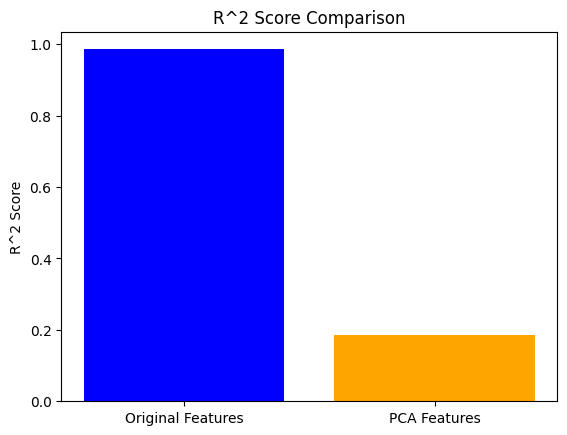

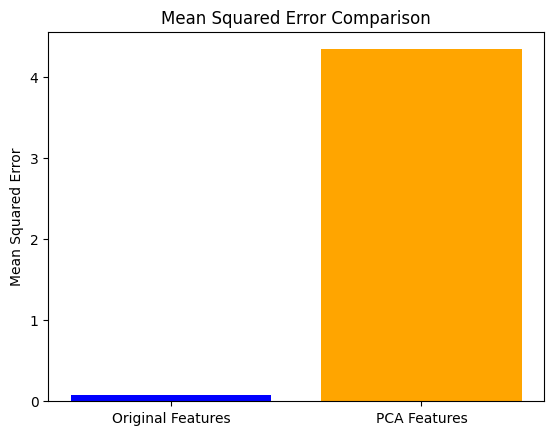

In [63]:
import matplotlib.pyplot as plt

# Compare performance
labels = ['Original Features', 'PCA Features']
r2_scores = [r2_original, r2_pca]
mse_scores = [mse_original, mse_pca]

# R^2 Score Bar Plot
plt.bar(labels, r2_scores, color=['blue', 'orange'])
plt.title('R^2 Score Comparison')
plt.ylabel('R^2 Score')
plt.show()

# MSE Bar Plot
plt.bar(labels, mse_scores, color=['blue', 'orange'])
plt.title('Mean Squared Error Comparison')
plt.ylabel('Mean Squared Error')
plt.show()


In [59]:
from sklearn.feature_selection import SelectKBest, f_classif

# ANOVA F-test for numerical features
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)

# Feature scores
anova_scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
}).sort_values(by='Score', ascending=False)

display(anova_scores)

,Feature,Score
17,BPS,12048.888255
16,B,9407.007566
1,Mins,6708.391498
19,I,5230.082170
22,ICT,3902.415917
2,GS,3396.893715
8,CS,2354.466132
15,RC,1778.900958
4,A,1675.715399
21,T,1229.319032


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor


model = XGBRegressor(objective='reg:squarederror', random_state=42,tree_method='gpu_hist', predictor='gpu_predictor')
selector = RFE(model, n_features_to_select=15)
selector = selector.fit(X, y)

# Selected features
selected_features = X.columns[selector.support_]
print("Selected Features:", selected_features)

KeyboardInterrupt: 

BPS                               0.569266
B                                 0.093111
A                                 0.067504
Mins                              0.049697
GS                                0.047168
CS                                0.033501
YC                                0.022072
GC                                0.017835
RC                                0.017742
I                                 0.014428
OG                                0.011193
S                                 0.008678
Pen_Miss                          0.007088
T                                 0.006148
Price                             0.005086
C                                 0.004450
Pen_Save                          0.004003
ICT                               0.001959
strength_attack_away              0.001805
strength_defence_home             0.001529
strength_defence_away             0.001197
SB                                0.001175
strength_attack_home              0.001127
season     

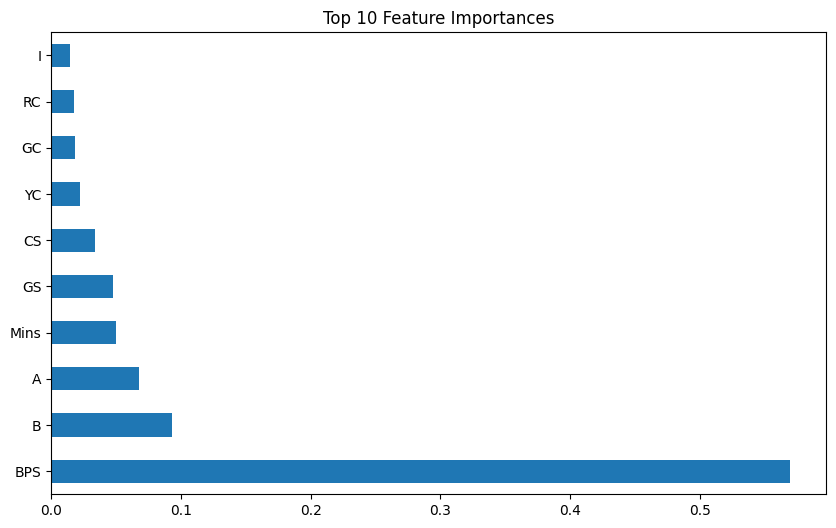

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train a Random Forest model
model = XGBRegressor(objective='reg:squarederror', random_state=42,tree_method='gpu_hist', predictor='gpu_predictor')
model.fit(X, y)

# Feature importances
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances)

# Plot feature importances
import matplotlib.pyplot as plt
importances[:10].plot(kind='barh', figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.show()


BPS                               0.498595
Mins                              0.149518
GS                                0.135536
A                                 0.060310
B                                 0.040887
GC                                0.037512
CS                                0.034139
YC                                0.016689
Price                             0.012702
T                                 0.012101
I                                 0.010413
S                                 0.006312
RC                                0.003973
SB                                0.003885
ICT                               0.003601
C                                 0.003279
OG                                0.002127
Tran_In                           0.001787
Tran_Out                          0.001205
Pen_Save                          0.001152
xA                                0.000664
Pen_Miss                          0.000569
xG                                0.000541
xGC        

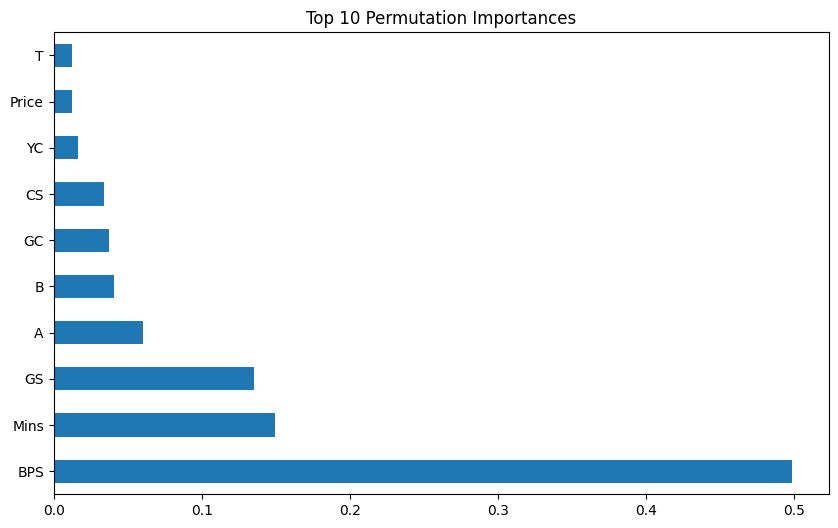

In [ ]:
from sklearn.inspection import permutation_importance

# Train a Random Forest model
model = XGBRegressor(objective='reg:squarederror', random_state=42,tree_method='gpu_hist', predictor='gpu_predictor')
model.fit(X, y)

# Compute permutation importance
result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
perm_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

print(perm_importances)

# Plot permutation importances
perm_importances[:10].plot(kind='barh', figsize=(10, 6))
plt.title("Top 10 Permutation Importances")
plt.show()


In [ ]:
import shap

# Train a Random Forest model
model = XGBRegressor(objective='reg:squarederror', random_state=42,tree_method='gpu_hist', predictor='gpu_predictor')
model.fit(X, y)

# SHAP explanation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X)


: 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
pca.fit(X)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.98768995 0.00670335]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
best_model = train_and_save_model(X_train, y_train)
best_model

[I 2024-11-17 22:55:12,119] A new study created in memory with name: no-name-3f0448ab-e706-462e-81e9-551095fdcc68


Starting a new Optuna study for hyperparameter tuning.


[I 2024-11-17 22:55:49,134] Trial 0 finished with value: 0.029449807007711038 and parameters: {'n_estimators': 490, 'learning_rate': 0.21630563859801868, 'max_depth': 2, 'min_child_weight': 1, 'subsample': 0.8632553420917028, 'colsample_bytree': 0.7152085121869104, 'gamma': 0.201607626272774, 'reg_alpha': 0.34441695640316894, 'reg_lambda': 0.7595656063622399}. Best is trial 0 with value: 0.029449807007711038.
[I 2024-11-17 22:56:12,455] Trial 1 finished with value: 0.03728581853328864 and parameters: {'n_estimators': 390, 'learning_rate': 0.22718756036074444, 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.7708410170820049, 'colsample_bytree': 0.5779978820619043, 'gamma': 0.11008527054509583, 'reg_alpha': 0.45324726995529147, 'reg_lambda': 0.8558736449688524}. Best is trial 0 with value: 0.029449807007711038.
[I 2024-11-17 22:56:36,382] Trial 2 finished with value: 0.03391687491078361 and parameters: {'n_estimators': 350, 'learning_rate': 0.21376325061650603, 'max_depth': 8, 'min

Optuna study saved.
Starting new model training with tuned hyperparameters.
[0]	validation_0-rmse:1.86296
[1]	validation_0-rmse:1.50487
[2]	validation_0-rmse:1.21516
[3]	validation_0-rmse:0.99510
[4]	validation_0-rmse:0.82046
[5]	validation_0-rmse:0.68036
[6]	validation_0-rmse:0.56344
[7]	validation_0-rmse:0.47623
[8]	validation_0-rmse:0.40714
[9]	validation_0-rmse:0.35419
[10]	validation_0-rmse:0.31618
[11]	validation_0-rmse:0.27952
[12]	validation_0-rmse:0.25866
[13]	validation_0-rmse:0.23961
[14]	validation_0-rmse:0.22077
[15]	validation_0-rmse:0.20690
[16]	validation_0-rmse:0.20021
[17]	validation_0-rmse:0.18668
[18]	validation_0-rmse:0.18080
[19]	validation_0-rmse:0.17340
[20]	validation_0-rmse:0.16932
[21]	validation_0-rmse:0.16680
[22]	validation_0-rmse:0.16380
[23]	validation_0-rmse:0.16129
[24]	validation_0-rmse:0.15813
[25]	validation_0-rmse:0.15614
[26]	validation_0-rmse:0.15301
[27]	validation_0-rmse:0.15211
[28]	validation_0-rmse:0.14950
[29]	validation_0-rmse:0.14823
[30]

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6445238644477767, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.021634248762002616,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2032310031180017,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=140, n_jobs=None,
             num_parallel_tree=None, predictor='gpu_predictor', ...)

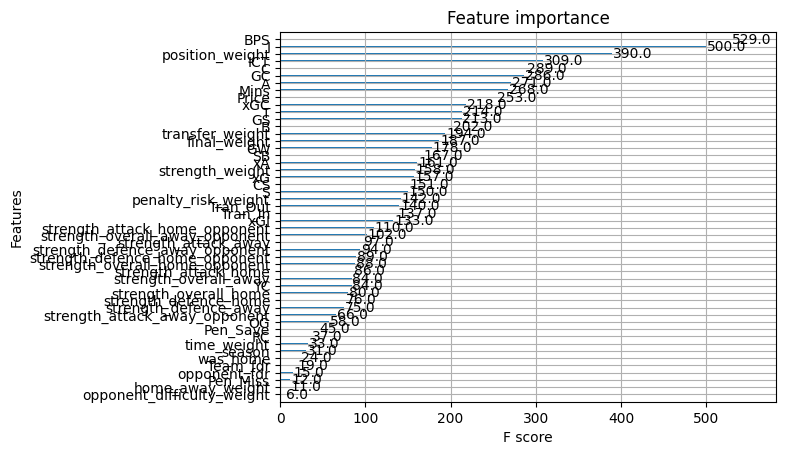

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(best_model)
plt.show()

In [ ]:
ssuiio=df_next_fixt_gw

In [ ]:
XX = ssuiio[features]

KeyError: "['position_weight', 'home_away_weight', 'time_weight', 'strength_weight', 'final_weight', 'transfer_weight', 'opponent_difficulty_weight', 'penalty_risk_weight'] not in index"

In [ ]:
azdazdazd=best_model.predict(XX)

In [ ]:
ssuiio['prediction']=azdazdazd

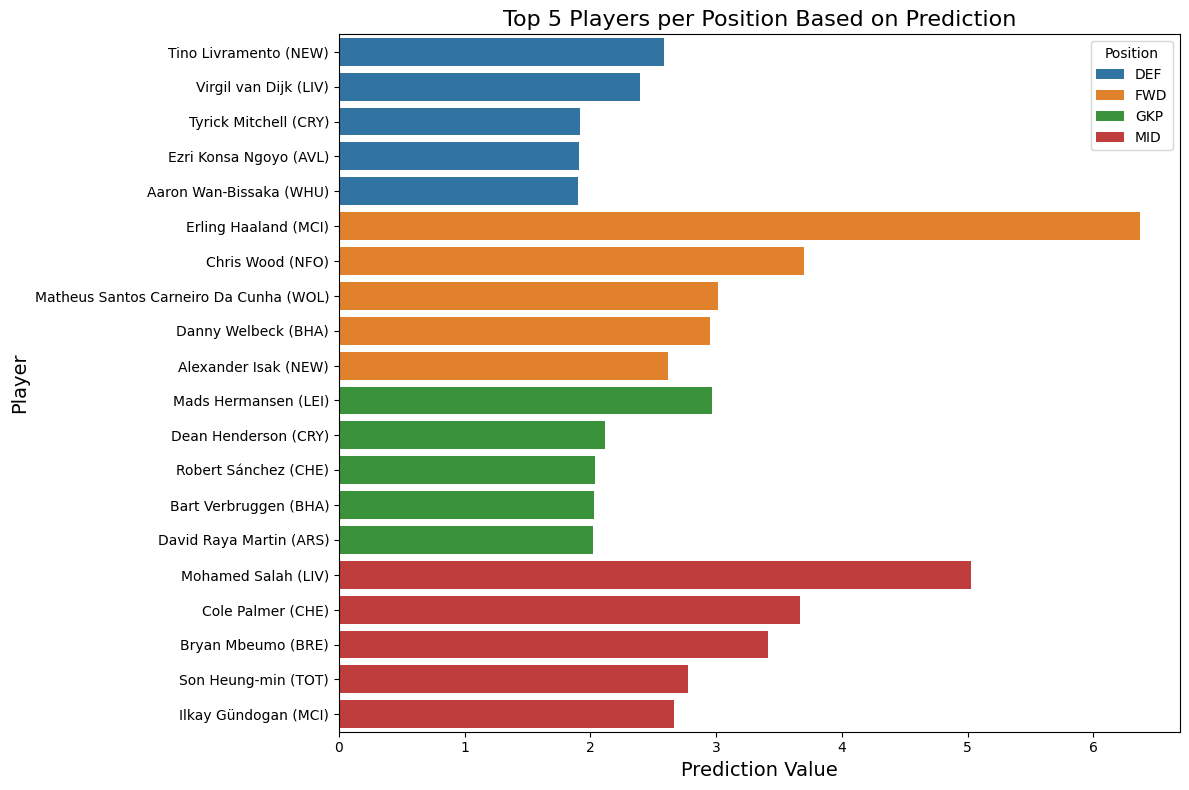

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the dataframe by 'Pos' and 'prediction' to get the top 5 players per position
top_players_per_pos = ssuiio.sort_values(by=['Pos', 'prediction'], ascending=[True, False])

# Group by position and select the top 5 players
top_5_players = top_players_per_pos.groupby('Pos').head(5)

# Create a plot for the top 5 players per position
plt.figure(figsize=(12, 8))
sns.barplot(data=top_5_players, x='prediction', y='Player', hue='Pos', dodge=False)

# Title and labels
plt.title('Top 5 Players per Position Based on Prediction', fontsize=16)
plt.xlabel('Prediction Value', fontsize=14)
plt.ylabel('Player', fontsize=14)
plt.legend(title='Position')

# Display the plot
plt.tight_layout()
plt.show()